In [28]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart.csv')

In [8]:
# Check for duplicate rows
print(data.duplicated().sum())

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Verify that duplicate rows have been removed
print(data.duplicated().sum())

# Convert the 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Explore data types and summary statistics
print(data.info())
print(data.describe())

0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
None
             Store                 Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                 6435  6.435000e+03   6435.000000   
mean     23.000000  2011-06-17 00:00:00  1.046965e+06      0.069930   
min       1.000000  2010-02-05 00:00:00  2.099862e+05      0.000000   
25%      12.000000  2010-10-08

In [7]:
# Convert Date from object to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [9]:
# Fill or drop missing values based on EDA findings
data.fillna(method='ffill', inplace=True)

<ipython-input-9-d1b9e570ec11>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [10]:
# Extract year and month for trend analysis
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Calculate weekly average sales for each store (helps in trend analysis)
weekly_avg_sales = data.groupby(['Store', 'Year', 'Month'])['Weekly_Sales'].mean().reset_index()


In [12]:
# Extract year and month for trend analysis
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Calculate weekly average sales for each store (helps in trend analysis)
weekly_avg_sales = data.groupby(['Store', 'Year', 'Month'])['Weekly_Sales'].mean().reset_index()


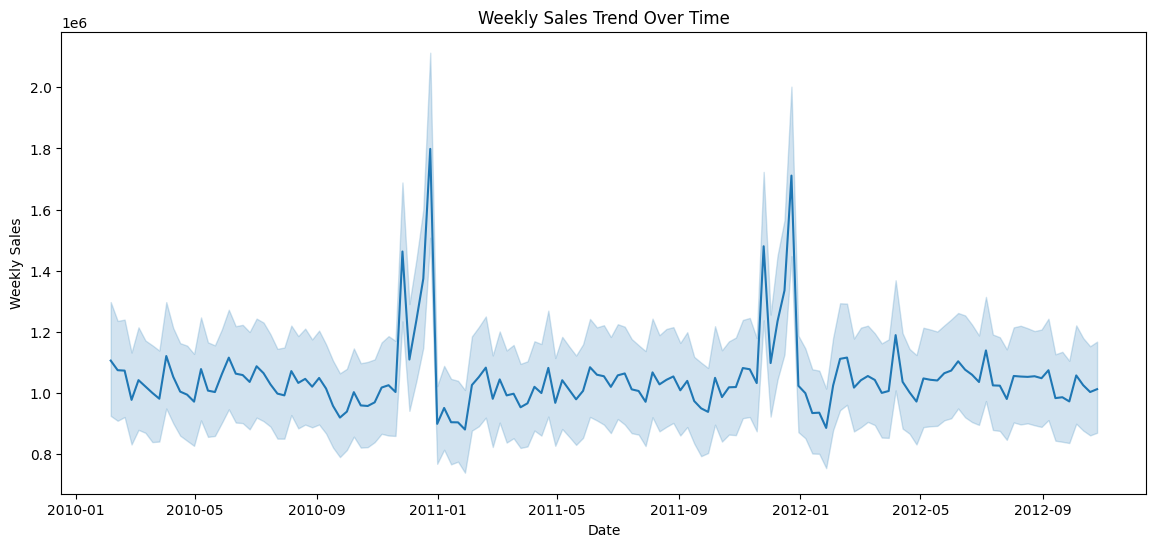

In [13]:
# Plot total weekly sales over time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=data)
plt.title("Weekly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


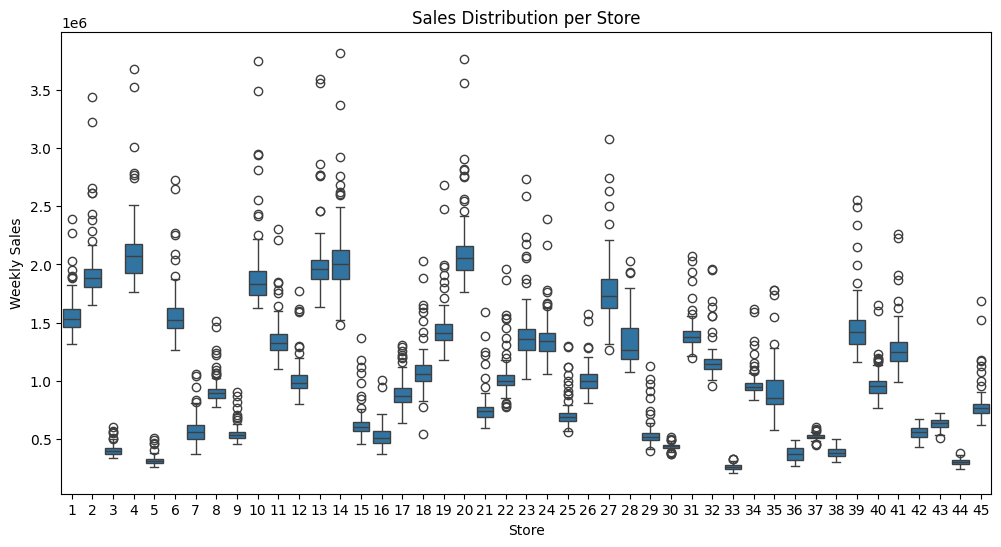

In [14]:
# Boxplot to show sales distribution across stores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=data)
plt.title("Sales Distribution per Store")
plt.xlabel("Store")
plt.ylabel("Weekly Sales")
plt.show()

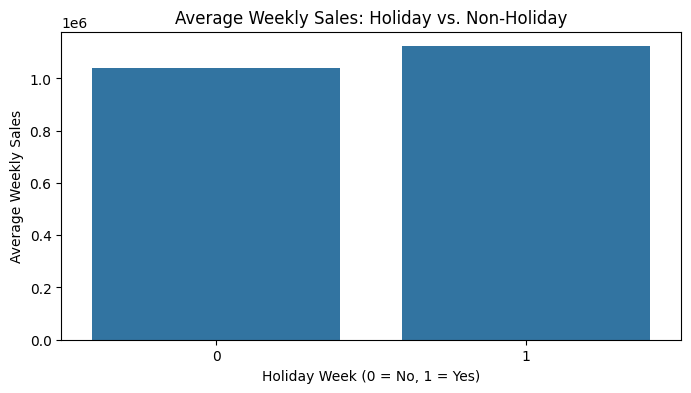

In [15]:
# Compare sales during holiday and non-holiday weeks
holiday_sales = data.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=holiday_sales)
plt.title("Average Weekly Sales: Holiday vs. Non-Holiday")
plt.xlabel("Holiday Week (0 = No, 1 = Yes)")
plt.ylabel("Average Weekly Sales")
plt.show()


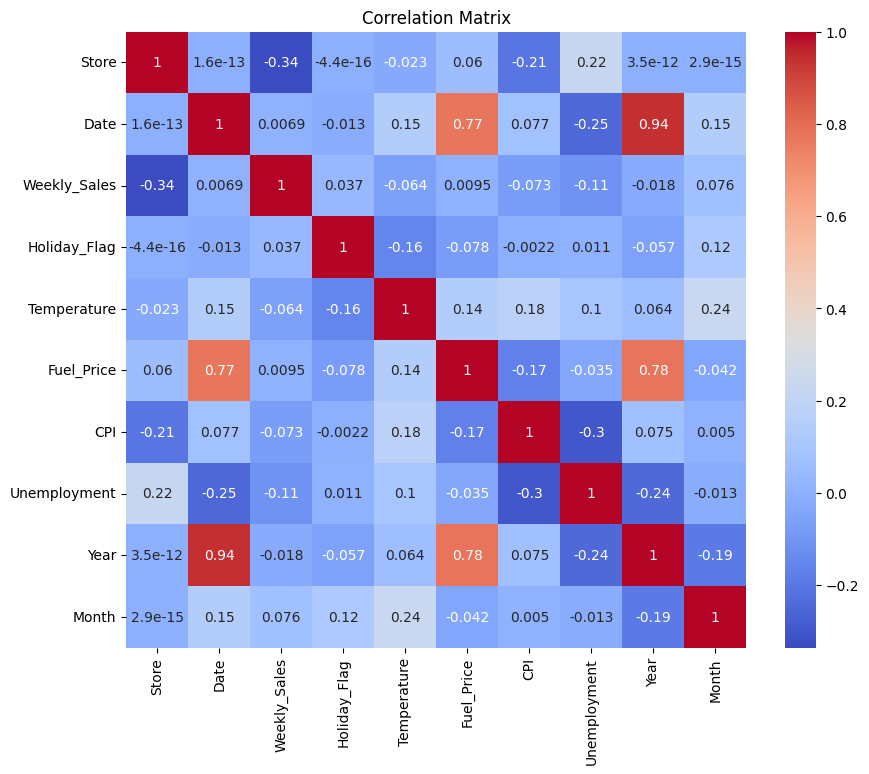

In [16]:
# Compute correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1905.518
Date:                Sat, 09 Nov 2024   AIC                           3817.037
Time:                        10:05:59   BIC                           3825.904
Sample:                    02-05-2010   HQIC                          3820.640
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3937      0.057      6.865      0.000       0.281       0.506
ma.L1         -0.9367      0.032    -29.470      0.000      -0.999      -0.874
sigma2      2.445e+10   3.44e-14    7.1e+23      0.0

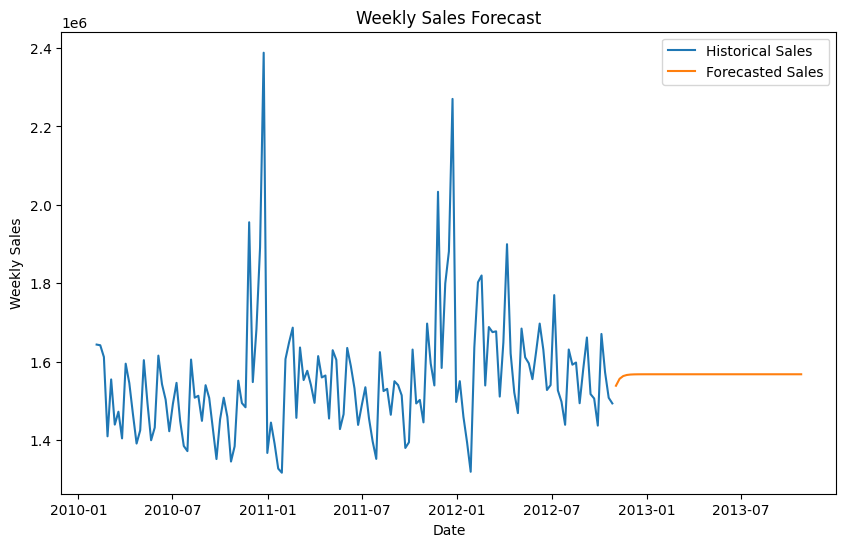

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Focus on sales data for a specific store
store_sales = data[data['Store'] == 1]  # e.g., Store 1
store_sales.set_index('Date', inplace=True)

# Fit ARIMA model
model = ARIMA(store_sales['Weekly_Sales'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast for next 12 months (52 weeks)
forecast = model_fit.forecast(steps=52)
plt.figure(figsize=(10, 6))
plt.plot(store_sales['Weekly_Sales'], label='Historical Sales')
plt.plot(forecast, label='Forecasted Sales')
plt.title("Weekly Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1905.518
Date:                Sat, 09 Nov 2024   AIC                           3817.037
Time:                        10:09:23   BIC                           3825.904
Sample:                             0   HQIC                          3820.640
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3937      0.057      6.865      0.000       0.281       0.506
ma.L1         -0.9367      0.032    -29.470      0.000      -0.999      -0.874
sigma2      2.445e+10   3.44e-14    7.1e+23      0.0

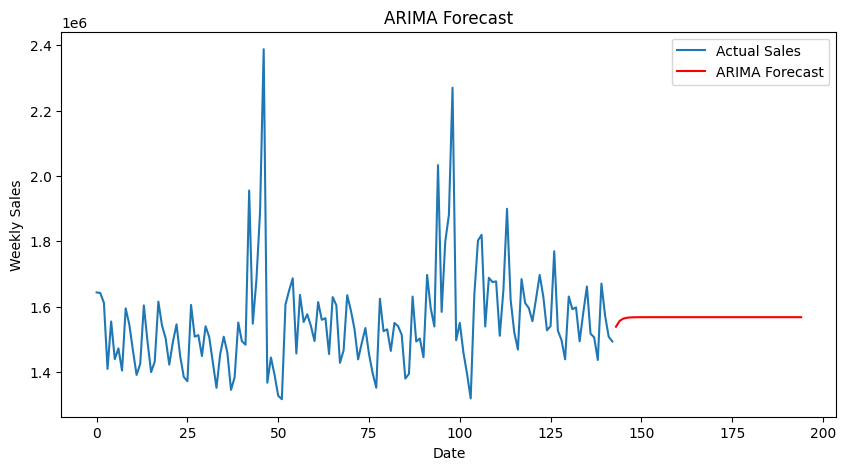

In [24]:
# ARIMA model
arima_model = ARIMA(store_data, order=(1, 1, 1))  # Adjust (p, d, q) parameters based on your data
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Forecast
arima_forecast = arima_fit.forecast(steps=52)  # Forecasting for the next 52 weeks
plt.figure(figsize=(10, 5))
plt.plot(store_data, label='Actual Sales')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1141.551
Date:                            Sat, 09 Nov 2024   AIC                           2293.102
Time:                                    10:09:22   BIC                           2305.601
Sample:                                         0   HQIC                          2298.142
                                            - 143                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1551      0.394      0.394      0.694      -0.616       0.926
ma.L1         -0.3463      0.383   

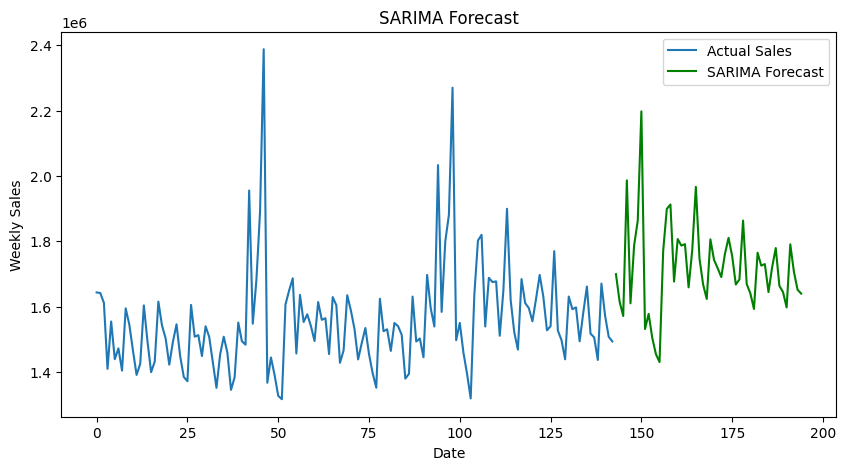

In [23]:
# SARIMA model
sarima_model = SARIMAX(store_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Adjust parameters
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

# Forecast
sarima_forecast = sarima_fit.forecast(steps=52)
plt.figure(figsize=(10, 5))
plt.plot(store_data, label='Actual Sales')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


                       ExponentialSmoothing Model Results                       
Dep. Variable:             Weekly_Sales   No. Observations:                  143
Model:             ExponentialSmoothing   SSE                   394377194296.541
Optimized:                         True   AIC                           3220.495
Trend:                         Additive   BIC                           3386.415
Seasonal:                      Additive   AICC                          3301.971
Seasonal Periods:                    52   Date:                 Sat, 09 Nov 2024
Box-Cox:                          False   Time:                         10:09:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha                 True
smoothing_trend          

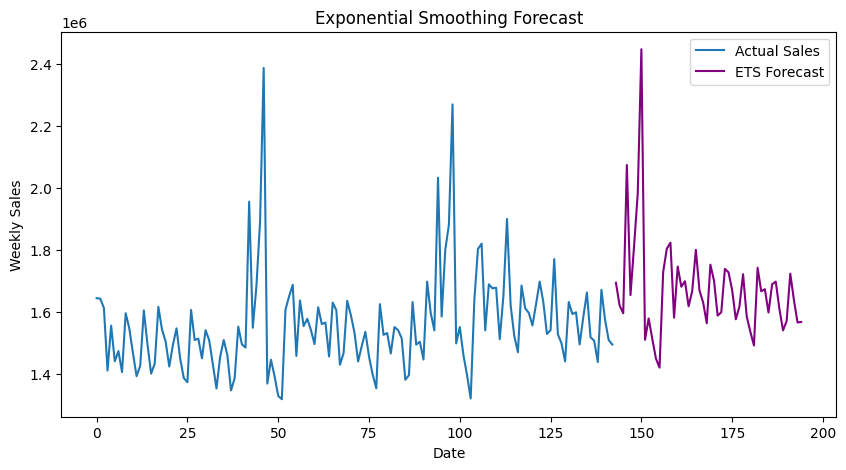

In [25]:
# Exponential Smoothing model
ets_model = ExponentialSmoothing(store_data, trend='add', seasonal='add', seasonal_periods=52)
ets_fit = ets_model.fit()
print(ets_fit.summary())

# Forecast
ets_forecast = ets_fit.forecast(steps=52)
plt.figure(figsize=(10, 5))
plt.plot(store_data, label='Actual Sales')
plt.plot(ets_forecast, label='ETS Forecast', color='purple')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error

# Define a function to compute MSE for all models
def calculate_mse(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    print("Mean Squared Error:", mse)
    return mse

# Calculate MSE for ARIMA model
calculate_mse(store_data[-52:], arima_forecast)

# Calculate MSE for SARIMA model
calculate_mse(store_data[-52:], sarima_forecast)

# Calculate MSE for ETS model
calculate_mse(store_data[-52:], ets_forecast)


Mean Squared Error: 28195914692.146267
Mean Squared Error: 13530007327.011955
Mean Squared Error: 5075461587.687824


5075461587.687824

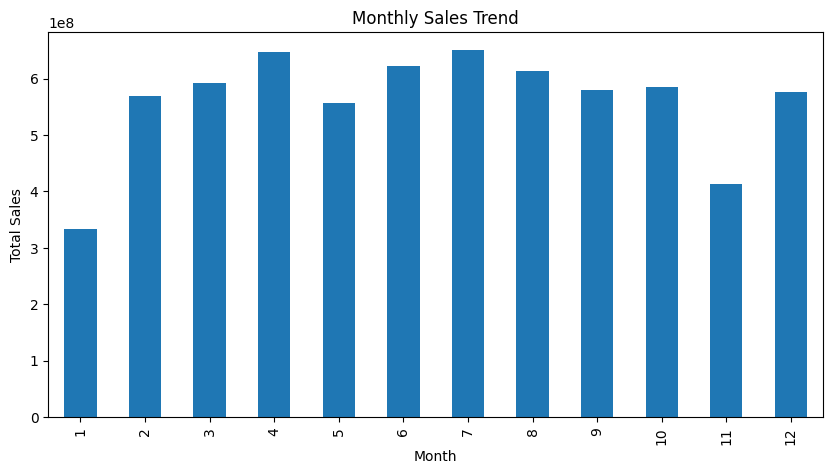

In [31]:
# Assuming 'Date' is the column containing date information
data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime objects
data.set_index('Date', inplace=True) # Set 'Date' column as the index

# 1. Seasonal Sales Trends
plt.figure(figsize=(10, 5))
data.groupby(data.index.month)['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [32]:
# 2. Holiday Impact on Sales
holiday_sales = data[data['Holiday_Flag'] == 1]
non_holiday_sales = data[data['Holiday_Flag'] == 0]
avg_holiday_sales = holiday_sales['Weekly_Sales'].mean()
avg_non_holiday_sales = non_holiday_sales['Weekly_Sales'].mean()
print("Average Holiday Sales:", avg_holiday_sales)
print("Average Non-Holiday Sales:", avg_non_holiday_sales)

Average Holiday Sales: 1122887.8923555557
Average Non-Holiday Sales: 1041256.3802088555


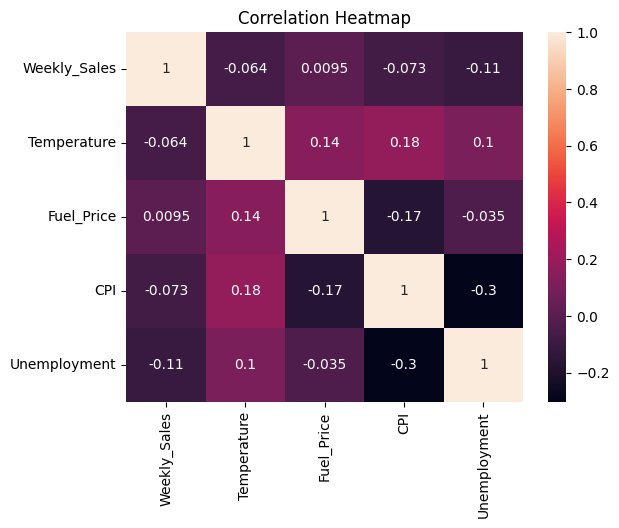

In [33]:
# 3. Effect of External Factors
correlations = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(correlations, annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [35]:
# 4. Top-Performing vs. Underperforming Stores
store_sales = data.groupby('Store')['Weekly_Sales'].sum()
top_stores = store_sales.nlargest(5)
bottom_stores = store_sales.nsmallest(5)
print("Top Performing Stores:\n", top_stores)
print("Underperforming Stores:\n", bottom_stores)

Top Performing Stores:
 Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
Name: Weekly_Sales, dtype: float64
Underperforming Stores:
 Store
33    37160221.96
44    43293087.84
5     45475688.90
36    53412214.97
38    55159626.42
Name: Weekly_Sales, dtype: float64


In [36]:
# 5. Product-Specific Sales Patterns (Assuming "Category" column exists)
if 'Category' in data.columns:
    category_sales = data.groupby('Category')['Weekly_Sales'].sum()
    category_sales.plot(kind='bar', figsize=(10, 5))
    plt.title("Category Sales Distribution")
    plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


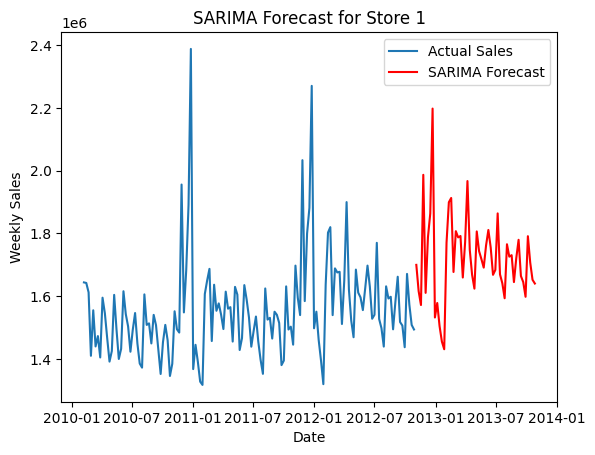

In [37]:
# 6. Forecasting Demand for Inventory Planning with SARIMA
store_data = data[data['Store'] == 1]['Weekly_Sales'].resample('W').sum()
sarima_model = SARIMAX(store_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=52)
plt.plot(store_data, label='Actual Sales')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

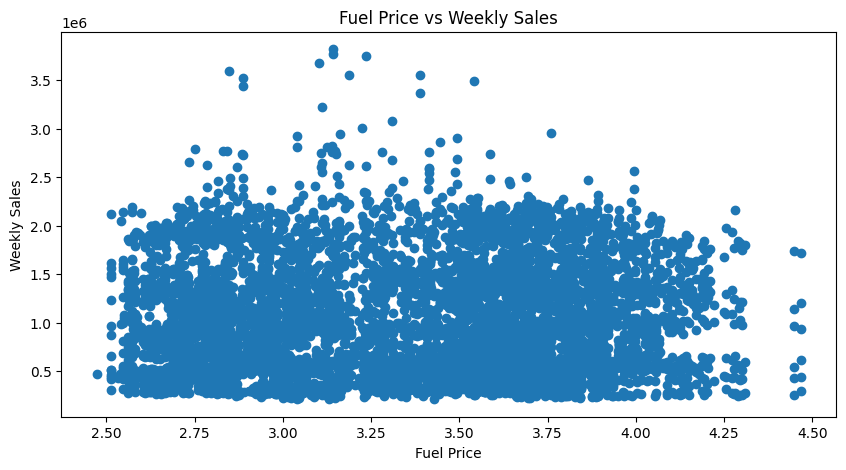

In [38]:
# 7. Impact of Pricing on Sales
plt.figure(figsize=(10, 5))
plt.scatter(data['Fuel_Price'], data['Weekly_Sales'])
plt.title("Fuel Price vs Weekly Sales")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.show()

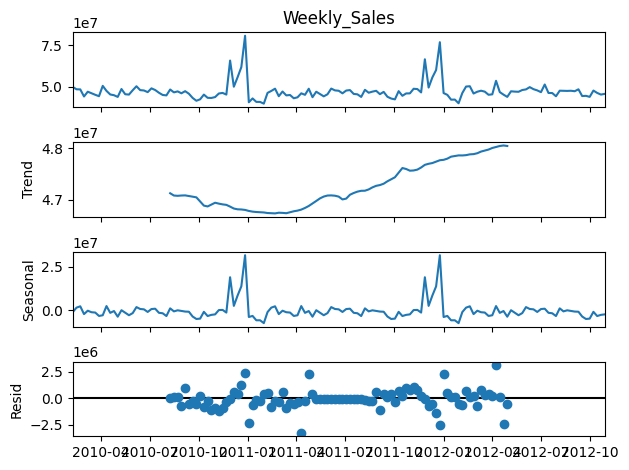

In [39]:
# 8. Sales Trends and Staff Allocation
weekly_sales = data.resample('W')['Weekly_Sales'].sum()
seasonal_decompose(weekly_sales, model='additive', period=52).plot()
plt.show()

In [43]:
# 9. Performance by Demographics and Region (Assuming "Region" column exists)
if 'Region' in data.columns:
    region_sales = data.groupby('Region')['Weekly_Sales'].sum()
    region_sales.plot(kind='bar', figsize=(10, 5))
    plt.title("Sales by Region")
    plt.show()

In [42]:
# 10. Customer Retention and Engagement (Identify weeks with sales drop)
data['Sales_Diff'] = data['Weekly_Sales'].diff()
low_sales_weeks = data[data['Sales_Diff'] < -data['Sales_Diff'].std()]
print("Weeks with Significant Sales Drop:\n", low_sales_weeks[['Weekly_Sales', 'Sales_Diff']])

Weeks with Significant Sales Drop:
             Weekly_Sales  Sales_Diff
Date                                
2010-02-26    1409727.59  -202240.58
2010-12-03    1548033.78  -407590.33
2010-12-31    1367320.01 -1020630.19
2011-02-25    1456800.28  -230042.50
2011-12-02    1584083.95  -449236.71
...                  ...         ...
2010-02-12     656988.64  -233700.87
2010-12-03     879244.90  -303255.26
2010-12-31     679156.20 -1003705.83
2011-12-02     875699.81  -294973.13
2011-12-30     869403.63  -652554.36

[281 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


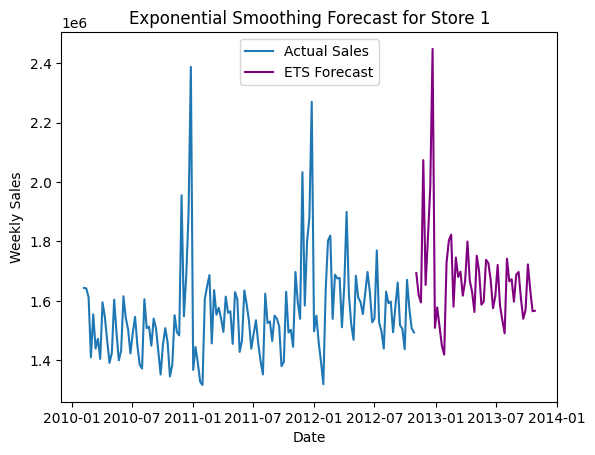

In [44]:
# Additional: Exponential Smoothing Forecast
ets_model = ExponentialSmoothing(store_data, trend='add', seasonal='add', seasonal_periods=52)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(steps=52)
plt.plot(store_data, label='Actual Sales')
plt.plot(ets_forecast, label='ETS Forecast', color='purple')
plt.title('Exponential Smoothing Forecast for Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [45]:
# List to store forecasts for each store
store_forecasts = {}

In [46]:
# Loop through each unique store in the dataset
for store in data['Store'].unique():
    # Filter data for the current store and resample to weekly sales
    store_data = data[data['Store'] == store]['Weekly_Sales'].resample('W').sum()

In [47]:
    # Fit a SARIMA model on the store's sales data
    model = SARIMAX(store_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Adjust SARIMA parameters if needed
    sarima_fit = model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [48]:
    # Forecast the next 12 weeks
    forecast = sarima_fit.forecast(steps=12)
    store_forecasts[store] = forecast  # Store the forecast for each store

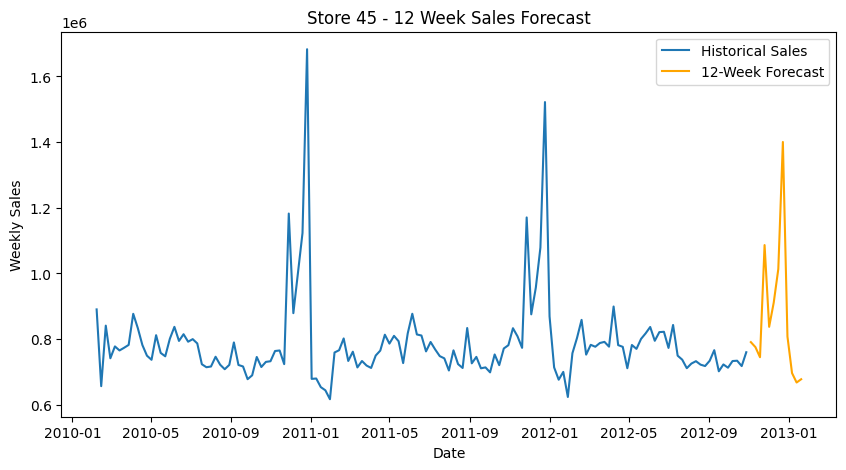

In [49]:
    # Plot the forecast for each store
    plt.figure(figsize=(10, 5))
    plt.plot(store_data, label='Historical Sales')
    plt.plot(forecast, label='12-Week Forecast', color='orange')
    plt.title(f'Store {store} - 12 Week Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

In [50]:
# Display forecasts for each store
for store, forecast in store_forecasts.items():
    print(f"Store {store} - 12-Week Sales Forecast:\n", forecast)

Store 45 - 12-Week Sales Forecast:
 2012-11-04    7.910655e+05
2012-11-11    7.758418e+05
2012-11-18    7.450611e+05
2012-11-25    1.086565e+06
2012-12-02    8.376259e+05
2012-12-09    9.113100e+05
2012-12-16    1.013530e+06
2012-12-23    1.400446e+06
2012-12-30    8.080803e+05
2013-01-06    6.968662e+05
2013-01-13    6.681062e+05
2013-01-20    6.780903e+05
Freq: W-SUN, Name: predicted_mean, dtype: float64
